# Red Neuronal con 1 capa intermedia
Integrantes:

Yeison Idarraga Chavarria

Juan Camilo Agudelo Aquite

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import warnings
#suppress warnings
warnings.filterwarnings('ignore')

import scipy.io

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/MyDrive/Colab Notebooks/IA/Redes_Neuronales/1 Capa intermedia/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/IA/Redes_Neuronales/1 Capa intermedia


In [ ]:
# Importar funciones de archivos .py
from RandParametros import randParametros
from fming import fmincg # función de optimización
from organizarBeta import organizarBeta
from sigmoid import sigmoid
from sigmoidGradiente import sigmoidGradiente


In [ ]:
mat = scipy.io.loadmat('datos4.mat')
x_data = mat['X']; #5000 X 400
y_data = mat['y']; #5000 X 1
y_data[y_data == 10] = 0; #cambiamos todas las Y = 10 por Y = 0
#print(y_data[:, 0])

La imagen corrsponde al número: [0]


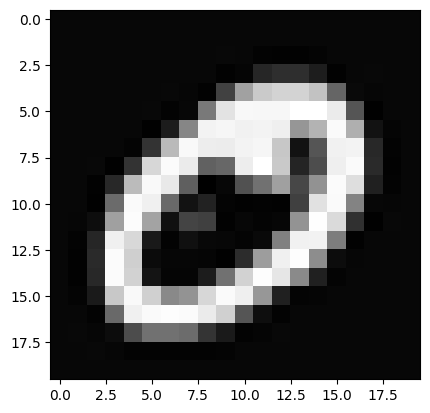

In [ ]:
#Es una celda opcional, para tener un ejemplo para visualizar imagenes
cont = 0
DatSetImage = np.zeros((20,20)) # Es la matriz que contiene cada pixel de la imagen a pintar
ImageNumber = 499 #Número de imagen que quiero visualizar

for i in range(20):
  for j in range(20):
    DatSetImage[j,i] = x_data[ImageNumber,cont]
    cont+=1

plt.imshow(DatSetImage, cmap='gray')
print('La imagen corrsponde al número:',y_data[ImageNumber])

In [ ]:
#Dividir datos en Entrenamiento en 70% y 30%, se entrena con el 70% y se calculan las metricas con el 30%
x_data_30 = np.zeros((0, x_data.shape[1]))
y_data_30 = np.zeros((0, y_data.shape[1]))

x_data_70 = np.zeros((0, x_data.shape[1]))
y_data_70 = np.zeros((0, y_data.shape[1]))

for i in range(0, x_data.shape[0], 500):
    x_data_30 = np.vstack((x_data_30, x_data[i:i+int(0.3*500), :]))
    x_data_70 = np.vstack((x_data_70, x_data[i+int(0.3*500):i+500, :]))

for i in range(0, y_data.shape[0], 500):
    y_data_30 = np.vstack((y_data_30, y_data[i:i+int(0.3*500), :]))
    y_data_70 = np.vstack((y_data_70, y_data[i+int(0.3*500):i+500, :]))

In [ ]:
m = x_data_70.shape[0] # m = 3500
print('m:',m)

Beta1_grad = 0;
Beta2_grad = 0;

tamano_capa_entrada  = 400;
tamano_capa_media = 25;
num_salidas =  10;

m: 3500


In [ ]:
#Inicializar las matrices Beta con datos random
Beta1_inicial = randParametros(tamano_capa_entrada,tamano_capa_media);
Beta2_inicial = randParametros(tamano_capa_media, num_salidas);

parametros_Beta_Iniciales = np.concatenate((Beta1_inicial, Beta2_inicial),axis=None)
# print(parametros_Beta_Iniciales.shape)
parametros_Beta_Iniciales = np.reshape(parametros_Beta_Iniciales,(parametros_Beta_Iniciales.shape[0],))
# print(parametros_Beta_Iniciales.shape)

In [ ]:
[Beta1,Beta2] = organizarBeta(tamano_capa_media,tamano_capa_entrada,num_salidas,parametros_Beta_Iniciales)

# Entrenamiento de la Red Neuronal

In [ ]:
def nnTraining(nn_params, tamano_capa_entrada, tamano_capa_media, num_salidas, x, y, Lambda, m):
  [Beta1, Beta2]=organizarBeta(tamano_capa_media, tamano_capa_entrada, num_salidas, nn_params)
  acumulador1 = 0
  acumulador2 = 0
  J_part_1 = 0
  for t in range(m):
    #Fordward Propagation
    x1 =x[t,:] #1X400

    #De capa 1 a capa 2
    a1 = np.reshape(np.concatenate((1,x1),axis=None),(401,1)) #401x1
    z2 = np.dot(Beta1, a1) #(25,1)
    a2 = sigmoid(z2) #(25,1)

    #De capa 2 a capa 3
    a2 = np.reshape(np.concatenate((1,a2),axis=None),(26,1))# 26X1
    z3 = np.dot(Beta2, a2) # 10x1
    a3 = np.reshape(sigmoid(z3),(10,1)) # 10x1 es la salida

    #Paso intermedio
    y_data_vector = np.zeros((a3.shape[0],a3.shape[1])) # 10x1
    valorY = int(y[t,0]) # Número de la salida que corresponde a la imagen
    y_data_vector[valorY] = 1 # 10x1

    #Propagacionhaciaatras
    d3 = a3 - y_data_vector #debe ser 10x1
    d2 = np.multiply((np.dot(Beta2[:,1:].transpose(), d3)), np.reshape(sigmoidGradiente(z2),(z2.shape[0],z2.shape[1]))) #debe ser 25x1

    #Acumuladores
    # print('a1',a1.shape)
    # print('d2',d2.shape)
    acumulador1 += np.dot(a1, d2.transpose())
    acumulador2 += np.dot(a2, d3.transpose())

    #Funcioncost(J)parte1
    J_part_1 += np.sum((np.multiply(y_data_vector,np.log(a3)))+(np.multiply((1 - y_data_vector),np.log(1-a3))))

  #Funcioncost(J)parte2
  sumaB1 = np.sum(np.square(Beta1[:, 1:])) #Es un escalar
  sumaB2 = np.sum(np.square(Beta2[:, 1:])) #Es un escalar
  J=(-1/m) * J_part_1 + ((Lambda / (2*m)) * (sumaB1 + sumaB2)) #Es un escalar

  #Calculamosgradientes
  tempBeta1 = np.copy(Beta1)
  tempBeta1[:, 0] = 0
  Beta1_grad = (1 / m) * (acumulador1.transpose() + (Lambda * tempBeta1)) # 25 x 401

  tempBeta2 = np.copy(Beta2)
  tempBeta2[:, 0] = 0
  Beta2_grad = (1 / m) * (acumulador2.transpose() + (Lambda * tempBeta2)) # 10x26

  grad = np.concatenate((Beta1_grad,Beta2_grad),axis=None) # 10285 x 1
  # print('grad:', grad.shape)
  retornar = [J,grad]

  return retornar

In [ ]:
#Celda de prueba
Lambda = 0.1
retornar = nnTraining(parametros_Beta_Iniciales, tamano_capa_entrada, tamano_capa_media, num_salidas, x_data_70, y_data_70, Lambda, m)
print(retornar[0])

6.9287552481323225


In [ ]:
def costFunction(p):
    ret = nnTraining(p, tamano_capa_entrada, tamano_capa_media, num_salidas, x_data_30, y_data_30, Lambda, m)
    return ret

In [ ]:
m = 1500
options = {'maxiter' : 50}
Lambda = 0.1
parametros_Beta_Finales = fmincg(costFunction, parametros_Beta_Iniciales, options)

Iteration 1 | Cost: 3.260584 
Iteration 2 | Cost: 3.234307 
Iteration 3 | Cost: 3.154033 
Iteration 4 | Cost: 2.914708 
Iteration 5 | Cost: 2.615159 
Iteration 6 | Cost: 2.466862 
Iteration 7 | Cost: 2.168585 
Iteration 8 | Cost: 2.085044 
Iteration 9 | Cost: 2.031658 
Iteration 10 | Cost: 1.756376 
Iteration 11 | Cost: 1.651306 
Iteration 12 | Cost: 1.526712 
Iteration 13 | Cost: 1.435547 
Iteration 14 | Cost: 1.338329 
Iteration 15 | Cost: 1.194275 
Iteration 16 | Cost: 1.165510 
Iteration 17 | Cost: 1.128920 
Iteration 18 | Cost: 1.053360 
Iteration 19 | Cost: 1.009112 
Iteration 20 | Cost: 0.960133 
Iteration 21 | Cost: 0.908141 
Iteration 22 | Cost: 0.860470 
Iteration 23 | Cost: 0.835638 
Iteration 24 | Cost: 0.814439 
Iteration 25 | Cost: 0.751175 
Iteration 26 | Cost: 0.710435 
Iteration 27 | Cost: 0.673141 
Iteration 28 | Cost: 0.623062 
Iteration 29 | Cost: 0.590297 
Iteration 30 | Cost: 0.557395 
Iteration 31 | Cost: 0.537818 
Iteration 32 | Cost: 0.525287 
Iteration 33 | Co

In [ ]:
[Beta1,Beta2] = organizarBeta(tamano_capa_media,tamano_capa_entrada,num_salidas,parametros_Beta_Finales)
print(len(parametros_Beta_Finales))
# print(Beta2)

3


In [ ]:
#Cálcular Matriz de Confusión con el 30% de los datos
m = len(x_data_30)
matrizConf = np.zeros((10,10))

for t in range(m):
  #Propagacion hacia adelante
  x1 = x_data_30[t,:] #1X400

  #De capa 1 a capa 2
  a1 = np.reshape(np.concatenate((1,x1),axis=None),(401,1)) #401x1
  z2 = np.dot(Beta1, a1) #(25,1)
  a2 = sigmoid(z2) #(25,1)

  #De capa 2 a capa 3
  a2 = np.reshape(np.concatenate((1,a2),axis=None),(26,1))# 26X1
  z3 = np.dot(Beta2, a2) # 10x1
  a3 = np.reshape(sigmoid(z3),(10,1)) # 10x1 es la salida

  posicion = np.argmax(a3)
  matrizConf[int(y_data_30[t]), int(posicion)] = matrizConf[int(y_data_30[t]), int(posicion)] + 1

print(matrizConf)


[[149.   0.   0.   0.   0.   0.   0.   0.   1.   0.]
 [  0. 147.   0.   1.   0.   1.   0.   1.   0.   0.]
 [  0.   0. 149.   0.   0.   0.   0.   0.   0.   1.]
 [  0.   0.   1. 146.   1.   1.   0.   1.   0.   0.]
 [  0.   1.   0.   0. 148.   0.   1.   0.   0.   0.]
 [  0.   0.   2.   2.   1. 145.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0. 150.   0.   0.   0.]
 [  0.   0.   1.   0.   0.   0.   0. 148.   0.   1.]
 [  0.   0.   0.   0.   0.   1.   0.   0. 149.   0.]
 [  1.   0.   0.   1.   0.   0.   0.   2.   1. 145.]]


In [ ]:
#Cálculo de la presición del modelo, según la Matríz de confusión

acumuladorMatriz = 0
for i in range(10):
  acumuladorMatriz += int(matrizConf[i,i])

exactitud = round(acumuladorMatriz / m, 4)
print('Accuracy:', exactitud)
print('Porcentaje de excatitud del modelo:',  round(exactitud * 100, 4), '%')

Accuracy: 0.984
Porcentaje de excatitud del modelo: 98.4 %
